### In this project, I have used the FastAI framework for performing semantic image segmentation on the CamVid dataset. 
---
The Cambridge-driving Labeled Video Database (CamVid) is the first collection of videos with object class semantic labels, complete with metadata. The database provides ground truth labels that associate each pixel with one of 32 semantic classes.

More on this dataset can be found on their official website [here](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/).

---
I'm going to be using [fastai datasets](https://course.fast.ai/datasets) for importing the CamVid dataset to my notebook.


We start by importing all the required packages for performing this semantic segmentation task. This includes the matplotlib package for data visualisation, and some fastai packages for performing the actual segmentation task.

In [1]:
# matplotlib 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai packages
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

# Setting up 
Here, we'll first download the dataset that we need and then start exploring it to gain more insights.

In [ ]:
# Downloading the CamVid dataset
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

We can see that there are four paths shown above. The first two being text files while the other two being 'labels' and 'images'. It is pretty obvious that the last two files contain the labels and images that we are mainly concerned with. So let's explore these files in detail.

In [ ]:
# Setting the paths for labels and images
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
# Show some sample image paths
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08610.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008790.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f00990.png')]

In [ ]:
# Show some sample label paths
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_00450_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02280_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07590_P.png')]

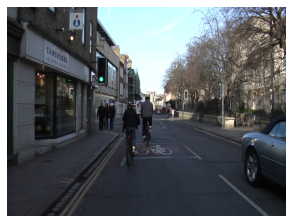

In [ ]:
# Show a sample image
img_f = fnames[219]
img = open_image(img_f)
img.show(figsize=(5, 5))

Now, it is somewhat noticeable from looking at the path names, that the labels' names are basically images' names but with an added suffix "_P" to them. However these are all jumbled up, which means that the first image in the image file does not correspond to the first label in the label file. Hence, we need to come up with a way to map the images with their labels in order for us to load our data for the model. And for that very purpose, a simple function can be devised, which is :

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

So now if we give an image input to this function, it will show us its label's path.

In [ ]:
get_y_fn(img_f)

PosixPath('/root/.fastai/data/camvid/labels/0016E5_08055_P.png')

Let's visualise the label of the image that we saw above.

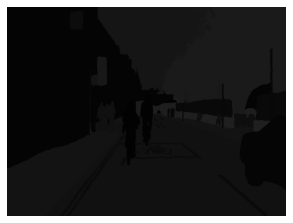

In [ ]:
img = open_image(get_y_fn(img_f))
img.show(figsize=(5,5))

Note that if we use the same method of `open_image()` for looking up a label, it is going to show us a dark image. This is because the labels that are provided to us are already segmented images. Hence we use a method called `open_mask()` for visualising label images.

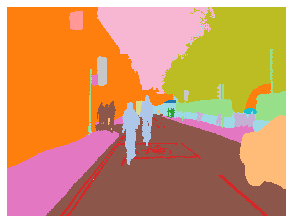

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

We can look at the shape and contents of the label data as:

In [ ]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

At this point, we can see what the `codes.txt` file has. 

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Clearly, `codes.txt` contains all the 32 classes that our images will potentially be segmented into.

Having explored our images and label files, its time for us to use them to prepare our actual data that will be used for building the model.

#### Checking with our memory constraints:

In [ ]:
defaults.device = torch.device('cuda') # makes sure the gpu is used

In [ ]:
torch.cuda.is_available()

True

In [ ]:
size = src_size//2     # for memory purposes

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200:
  bs=8
else:
  bs=4
  
print(f"using bs={bs}, because I have {free}MB of GPU RAM free")

using bs=8, because I have 16270MB of GPU RAM free


# Data building

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None

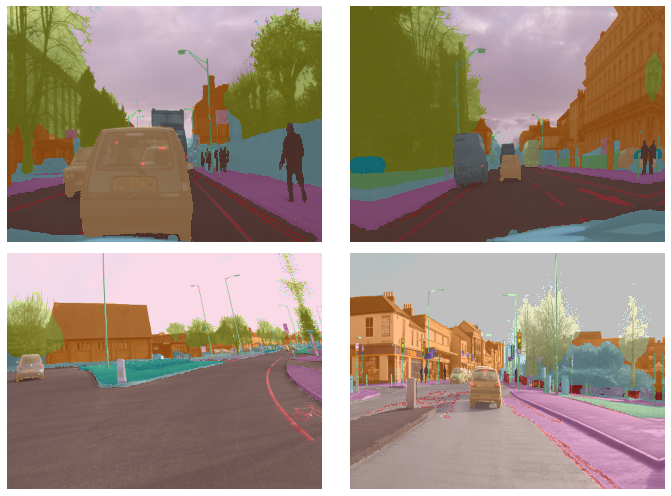

In [ ]:
# showing a random batch of data
data.show_batch(2, figsize=(10,7))

Because this is a segmentation task and we used *`SegmentationItemList.from_folder`*, fastai provides us with a very nice looking dataset that combines the images with their labels while showing the data samples.

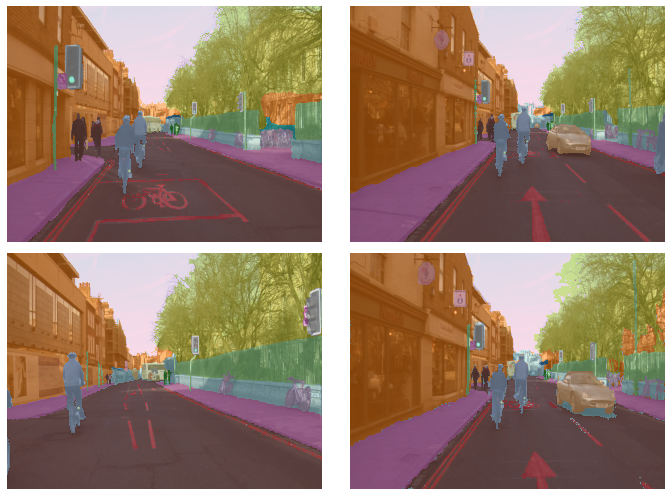

In [ ]:
# showing a random batch of validation data
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model building

We are going to be using a U-Net model, which is one of the most common architectures that are used for segmentation tasks.
A U-Net architecture looks something like this :
![U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)
More on this can be found [here](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

Also, we're going to be using a pre-trained model called ResNet34 inside the U-Net architecture.

In [ ]:
'''
We first have to create a custom accuracy function for our model because 
there are a few images with 'void' labels assigned to them, which we need 
to ignore while calculating accuracy.
'''

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
# Hyperparameters
metrics = acc_camvid
wd = 1e-2  # weight decay

In [ ]:
# create unet model
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


After we have our initial model ready, we have to find an appropriate learning rate(lr) to train our model. And for finding a lr, fastai gives us a very efficient way as shown below:

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-04
Min loss divided by 10: 6.31E-04


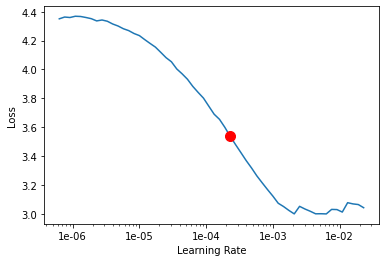

In [ ]:
learn.recorder.plot(suggestion=True)

The red dot on the graph recommends a lr that might be good for our training. The exact point that it corresponds to on the x-axis is also given to us at the top of the plot by the name 'Min numerical gradient'. We can simply use this number for our lr and we're good to go.

In [ ]:
min_grad_lr1 = learn.recorder.min_grad_lr
min_grad_lr1

0.00022908676527677726

In [ ]:
lr1 = min_grad_lr1

Training for 10 epochs:

In [ ]:
learn.fit_one_cycle(10, slice(lr1), pct_start=0.9)   # pc_start denotes the percentage of total number of epochs when learning rate rises during one cycle.

epoch,train_loss,valid_loss,acc_camvid,time
0,2.396499,1.661047,0.591230,00:59
1,1.410436,0.924968,0.795478,00:57
2,0.989255,0.733153,0.814343,00:57
3,0.797690,0.643526,0.839390,00:56
4,0.707708,0.585898,0.845879,00:56
5,0.636015,0.503530,0.865393,00:57
6,0.580359,0.505027,0.864382,00:57
7,0.528212,0.478005,0.861960,00:58
8,0.500426,0.441106,0.890183,00:57
9,0.444700,0.358000,0.896206,00:58


We are already at a pretty good accuracy of about 89% with seemingly good training and validation losses as well. We can also plot the losses to see their learning curve over batches processed. Ideally, we'd like to have both these losses get as low as possible and as close to each other as possible.

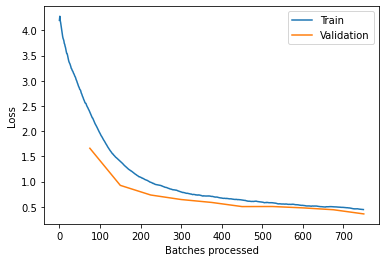

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

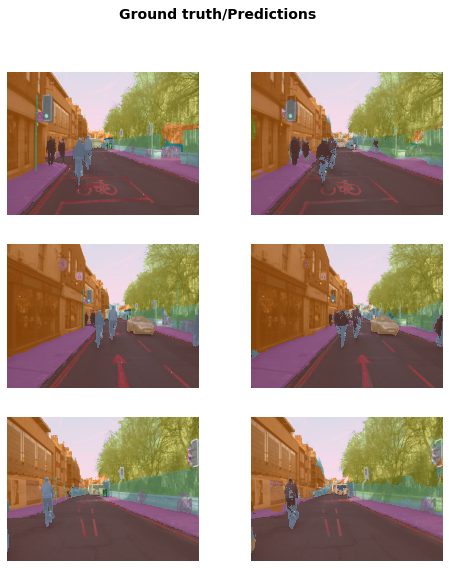

In [ ]:
# show some sample results
learn.show_results(rows=3, figsize=(8,9))

By looking at the sample results, we can notice that our model has got the overall predictions right, but needs to work more on some details.
For doing that, we need to `unfreeze` and train the previous layers to get a better sense of training this particular data that we have.

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 4.37E-06


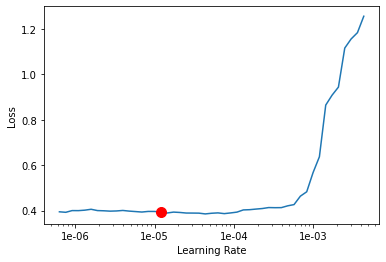

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr2 = learn.recorder.min_grad_lr
min_grad_lr2

1.202264434617413e-05

In [ ]:
lr2 = min_grad_lr2

In [ ]:
learn.fit_one_cycle(12, slice(lr2), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.395411,0.346060,0.898414,00:58
1,0.388325,0.342539,0.900186,00:57
2,0.383187,0.336313,0.902442,00:57
3,0.380019,0.336065,0.902056,00:57
4,0.375680,0.331252,0.903600,00:57
5,0.374451,0.332791,0.902482,00:57
6,0.371287,0.327359,0.904738,00:58
7,0.364534,0.325350,0.905629,00:57
8,0.359927,0.313877,0.909931,00:57
9,0.354473,0.314797,0.908610,00:58


So after unfreezing and training again with a new appropriate lr, we have increased the accuracy from 89% last time to 91% this time.

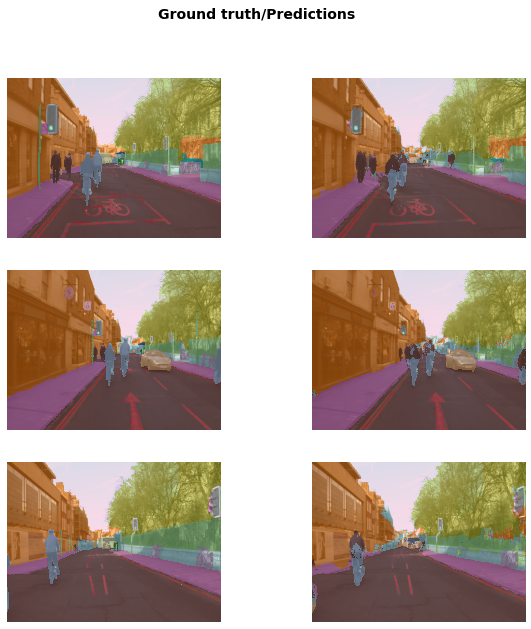

In [ ]:
# show some sample results
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:
learn.save('stage-2')

Now that we have trained our model on half of the dataset's size, we can use the same model and and train on all of the dataset at once (given that your system allows that much memory).
This can help the model learn better and hopefully give a higher accuracy.

So we are going to implement the same steps as we did above, but with full dataset as input this time.

In [ ]:
learn.destroy()   # optional 

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15567MB of GPU RAM free


In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');  # loading the previously saved model

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05
Min loss divided by 10: 1.58E-05


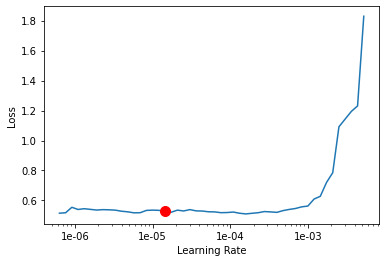

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr3 = learn.recorder.min_grad_lr
min_grad_lr3

1.4454397707459279e-05

In [ ]:
lr3 = min_grad_lr3

In [ ]:
learn.fit_one_cycle(10, slice(lr3), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.481461,0.364047,0.897063,03:16
1,0.459406,0.345827,0.900525,03:14
2,0.430379,0.343483,0.901072,03:14
3,0.414817,0.329761,0.904191,03:14
4,0.415066,0.326984,0.904850,03:14
5,0.383169,0.325777,0.905422,03:14
6,0.391337,0.323970,0.905347,03:14
7,0.371760,0.306865,0.910186,03:14
8,0.365334,0.293244,0.914709,03:14
9,0.348762,0.295059,0.914228,03:14


Clearly, we are already at a higher accuracy of 91.4% this time from 91.01% last time. 

In [ ]:
learn.save('stage-1-big')  #save the model

Again, unfreeze the model and train it for one last time.

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 7.59E-06


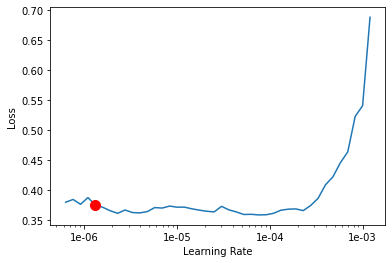

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr4 = learn.recorder.min_grad_lr
min_grad_lr4

1.3182567385564074e-06

In [ ]:
lr4 = min_grad_lr4

In [ ]:
learn.fit_one_cycle(10, slice(lr4, lr3/10))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.339950,0.297431,0.913378,03:21
1,0.356541,0.297911,0.913416,03:20
2,0.357280,0.295164,0.913747,03:20
3,0.332167,0.290425,0.915868,03:21
4,0.328935,0.287672,0.917607,03:20
5,0.327459,0.284918,0.917728,03:21
6,0.328348,0.290749,0.915594,03:20
7,0.332773,0.283536,0.917672,03:21
8,0.328447,0.287901,0.916632,03:20
9,0.316930,0.289541,0.916288,03:20


So we have arrived at an accuracy of **91.6%** which is higher than all the previous ones that we got. 

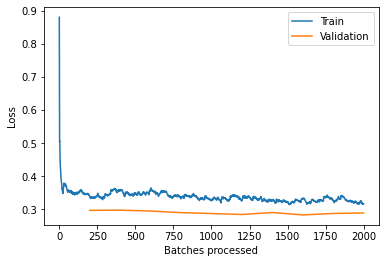

In [ ]:
learn.recorder.plot_losses()  # plotting the train and valid losses

Our losses are pretty low and close which is permissible at this point. We can thus be assured of a good model by now and save it for future use.

In [ ]:
learn.save('stage-2-big')

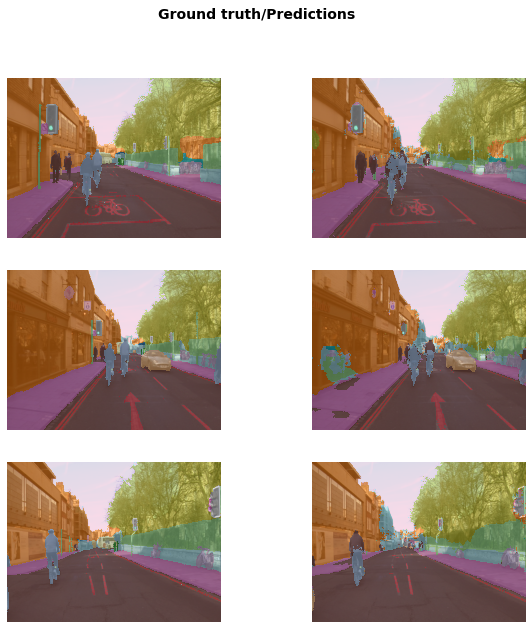

In [ ]:
# show some results
learn.show_results(rows=3, figsize=(10, 10))